<a href="https://colab.research.google.com/github/georgerieh/spotify-million-dataset/blob/main/Spotify_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import numpy as np
import cudf
from tqdm import tqdm
import torch
from scipy.sparse import csr_matrix as sp_csr_matrix, load_npz, save_npz
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import json
import faiss

In [67]:
!pip install faiss-cpu

# Plan

## Part 1. Build simple CF
## Part 2. EDA
## Part 3. Modification of CF
## Part 4. Evaluation


## Part 0
Load the dataset

In [68]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!unzip -q '/content/drive/MyDrive/spotify_million_playlist_dataset.zip' -d 'spotify_million_playlist_dataset'

In [ ]:
import json
import glob
import csv
import hashlib
import re
import cudf
from tqdm import tqdm

hash_to_song = {}
def stable_hash(s):
    # Shorten to 16 chars for a 64-bit int to save space
    return int(hashlib.md5(s.encode('utf-8')).hexdigest()[:16], 16)

def process_and_split_data():
    files = glob.glob("spotify_million_playlist_dataset/data/*.json")
    seen_songs = set()

    # Keep Metadata on Drive, but keep the heavy Interactions on Local VM first
    with open('/content/drive/MyDrive/spotify-challenge/song_library.csv', "w", newline="") as f_song, \
         open('/content/drive/MyDrive/spotify-challenge/playlist_library.csv', "w", newline="") as f_play:

        song_writer = csv.writer(f_song)
        play_writer = csv.writer(f_play)

        song_writer.writerow(["track_hash", "name", "artist", "album", "dur"])
        play_writer.writerow(["pid", "p_name", "is_shared", "n_tracks", "n_followers", 'n_albums'])

        all_interactions = []
        file_count = 0
        chunk_size = 50 # Write to parquet every 50 JSON files

        for file_name in tqdm(files):
            with open(file_name, "r") as jf:
                data = json.load(jf)
                for playlist in data["playlists"]:
                    if playlist['num_tracks'] >=10 and playlist['num_tracks']<=250: #check eda step
                      pid = playlist["pid"]
                      play_writer.writerow([
                            pid, playlist['name'], json.loads(playlist['collaborative']),
                            playlist['num_tracks'], playlist['num_followers'], playlist['num_albums']
                        ])

                      for track in playlist["tracks"]:
                          # Faster string cleaning than regex

                          clean_name = (track['track_name'] +'_'+ track['album_name']).lower()
                          clean_str = "".join(filter(str.isalnum, clean_name))
                          track_hash = stable_hash(clean_str)
                          all_interactions.append({'pid': pid, 'tid': track_hash, 'pos': track['pos'], 'added': 1})

                          if track_hash not in seen_songs:
                              song_writer.writerow([
                                  track_hash, track['track_name'], track['artist_name'],
                                  track['album_name'], track['duration_ms']
                              ])
                              seen_songs.add(track_hash)
                          if track_hash not in hash_to_song:
                            hash_to_song[track_hash] = (clean_name,track['track_uri'])

            file_count += 1
            if file_count % chunk_size == 0:
                df_chunk = cudf.DataFrame(all_interactions)
                df_chunk.to_parquet(f'/content/interactions_chunk_{file_count}.parquet', compression='snappy')
                all_interactions = []
        if all_interactions:
            df_chunk = cudf.DataFrame(all_interactions)
            df_chunk.to_parquet(f'/content/interactions_chunk_final.parquet', compression='snappy')

    # Final Step: Copy all chunks to Drive
    !mkdir -p /content/drive/MyDrive/spotify-challenge/interactions_parquet/
    !cp /content/*.parquet /content/drive/MyDrive/spotify-challenge/interactions_parquet/
    with open('/content/drive/MyDrive/spotify-challenge/hash_to_song.json', 'w') as h:
      json.dump(hash_to_song, h)

process_and_split_data()





In [88]:
# 1. Get a tid that exists in all_interactions
sample_tid = gdf['tid'][0]

print(f"Sample TID: {sample_tid}")
print(f"Type of TID: {type(sample_tid)}")

# 2. Check if it's in the dictionary
if sample_tid in hash_to_song:
    print("Found in hash_to_song!")
else:
    print("NOT found in hash_to_song.")

    # 3. Check for type mismatch
    keys = list(hash_to_song.keys())
    if len(keys) > 0:
        print(f"Example key in hash_to_song: {keys[0]}")
        print(f"Type of key in hash_to_song: {type(keys[0])}")

        # Check if casting fixes it
        if int(sample_tid) in hash_to_song:
            print("Casting to int fixed it!")
        elif str(sample_tid) in hash_to_song:
            print("Casting to str fixed it!")# hash_to_song[35741053422652519]

Sample TID: -35741053422652519
Type of TID: <class 'numpy.int64'>
NOT found in hash_to_song.
Example key in hash_to_song: 13588475414386435278
Type of key in hash_to_song: <class 'int'>


In [ ]:
!pip install fastparquet

In [ ]:
target_schema = {
    'pid': 'int32',
    'tid': 'int64',
    'pos': 'int16'
}
import glob
files = glob.glob('/content/drive/MyDrive/spotify-challenge/interactions_parquet/*.parquet')
list_of_gdfs = []
for f in files:
    temp_gdf = cudf.read_parquet(f)
    # Force the columns to match the target schema
    for col, dtype in target_schema.items():
        if col in temp_gdf.columns:
            temp_gdf[col] = temp_gdf[col].astype(dtype)
    list_of_gdfs.append(temp_gdf)

# Combine them safely
gdf = cudf.concat(list_of_gdfs)

# Define the path
output_path = '/content/drive/MyDrive/spotify-challenge/interactions_master.parquet'

# 1. Determine how many rows to handle at once (e.g., 5 million)
chunk_size = 5_000_000
total_rows = len(gdf)

print(f"Total rows to save: {total_rows:,}")

# 2. Use a loop to write the file in chunks
# We convert each chunk to a Pandas DataFrame (CPU) to free up GPU memory
for i in range(0, total_rows, chunk_size):
    start = i
    end = min(i + chunk_size, total_rows)

    # Slice the GPU dataframe and move ONLY that slice to CPU
    chunk_cpu = gdf.iloc[start:end].to_pandas()

    # For the first chunk, create the file. For others, append.
    if i == 0:
        chunk_cpu.to_parquet(output_path, engine='fastparquet', index=False, compression='snappy')
    else:
        # Note: fastparquet engine supports appending to the same file structure
        chunk_cpu.to_parquet(output_path, engine='fastparquet', index=False, compression='snappy', append=True)



In [ ]:
import cudf

# 1. Load the master interaction file
gdf = cudf.read_parquet('/content/drive/MyDrive/spotify-challenge/interactions_master.parquet')

# 2. Group by Playlist ID (pid) and count track IDs (tid)
# This calculates the size of every single playlist in the dataset
playlist_sizes = gdf.groupby('pid')['pos'].max()


max_songs = playlist_sizes.max()
min_songs = playlist_sizes.min()
avg_songs = playlist_sizes.mean()
print(f"Maximum songs in a single playlist: {max_songs}")
print(f"Minimum songs in a single playlist: {min_songs}")
print(f"Average songs per playlist: {avg_songs:.2f}")

Distribution of number of playlists bty numver of songs in it (previous run)

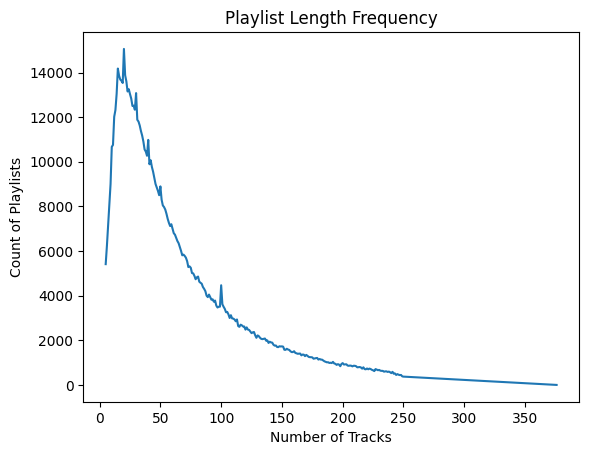

In [ ]:
playlist = cudf.read_csv('/content/drive/MyDrive/spotify-challenge/playlist_library.csv')

playlist['is_shared'].value_counts().to_pandas().plot(kind='bar')


at first, I was going to select only 'shared' playlists, as they are more in the state of 'done' than private ones. but since the absolute majority of playlists are private, I will not exclude them from the study

In [ ]:
playlist_map = {}
song_map = {}

next_playlist_idx = 0
next_song_idx = 0
parquet_file = pq.ParquetFile("/content/drive/MyDrive/spotify-challenge/interactions_master.parquet")
for i in tqdm(range(parquet_file.num_row_groups), desc="Processing Row Groups"):
    chunk = parquet_file.read_row_group(i).to_pandas()
    for row in chunk.itertuples():
        pid_hash = int(row.pid)
        sid_hash = int(row.tid)
        if pid_hash not in playlist_map:
            playlist_map[int(pid_hash)] = next_playlist_idx
            next_playlist_idx += 1
        if sid_hash not in song_map:
            song_map[int(sid_hash)] = next_song_idx
            next_song_idx += 1

with open('/content/drive/MyDrive/spotify-challenge/playlist_map.json', 'w') as pl, open('/content/drive/MyDrive/spotify-challenge/song_map.json', 'w') as so:
  json.dump(playlist_map, pl)
  json.dump(song_map, so)

In [ ]:
from scipy.sparse import coo_matrix, save_npz, load_npz

rows = []
cols = []
data_vals = []

parquet_file = pq.ParquetFile("/content/drive/MyDrive/spotify-challenge/interactions_master.parquet")
for i in tqdm(range(parquet_file.num_row_groups), desc="Processing Row Groups"):
    chunk = parquet_file.read_row_group(i).to_pandas()
    for row in chunk.itertuples():
        pid_idx = playlist_map[int(row.pid)]
        sid_idx = song_map[int(row.tid)]

        rows.append(pid_idx)
        cols.append(sid_idx)
        data_vals.append(1)  # binary interaction

interaction_matrix = coo_matrix(
    (data_vals, (rows, cols)),
    shape=(len(playlist_map), len(song_map))
)

save_npz('/content/drive/MyDrive/spotify-challenge/interaction.npz', interaction_matrix)
del interaction_matrix


In [ ]:
interaction_matrix = load_npz('/content/drive/MyDrive/spotify-challenge/interaction.npz')
interaction_matrix = interaction_matrix.tocsr()
save_npz('/content/drive/MyDrive/spotify-challenge/interaction_csr.npz', interaction_matrix)
del interaction_matrix


In [ ]:
all_recommendations = {}  # key = playlist index, value = list of top-n songs

def save_recommendations(playlist_idx, recommended_songs):
    all_recommendations[playlist_idx] = recommended_songs


In [ ]:
# import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix
from scipy.sparse import csr_matrix as sp_csr_matrix
def csr_to_torch_sparse(csr_matrix):
    coo = csr_matrix.tocoo()  # must be COO
    if coo.data.size == 0:
        # empty matrix → return a 0-valued sparse tensor
        indices = torch.zeros((2,0), dtype=torch.long)
        values  = torch.zeros((0,), dtype=torch.float32)
    else:
        indices = torch.tensor([coo.row, coo.col], dtype=torch.long)
        values  = torch.tensor(coo.data, dtype=torch.float32)  # must be float
    shape = coo.shape
    return torch.sparse_coo_tensor(indices, values, size=shape)

def compute_topk_similarity_gpu(
    sparse_x_batch_cpu: sp_csr_matrix,
    csr_matrix_all_cupy: cp_csr_matrix,
    top_k: int = 5,
    zero_self_similarity: bool = False,
    batch_offset: int = 0,
):
    # Convert CPU batch to GPU (CuPy)
    sparse_x_batch_gpu = cp_csr_matrix(sparse_x_batch_cpu)

    # Calculate L2 norms for normalization
    # Example: If a row is [3, 0, 4], power(2) is [9, 0, 16], sum is 25, sqrt is 5.
    all_norms = cp.sqrt(csr_matrix_all_cupy.power(2).sum(axis=1)).ravel()
    batch_norms = cp.sqrt(sparse_x_batch_gpu.power(2).sum(axis=1)).ravel()

    # Compute sparse dot product (Batch Matrix Multiplication)
    # ====== #
    # sparse_x_batch (2 rows) = [[1, 0], [0, 1]]
    # csr_matrix_all (3 rows) = [[1, 1], [1, 0], [0, 1]]
    # sim = batch @ all.T
    # sim result shape: (2, 3) -> Matrix of dot products
    # sim = [[1, 1, 0],
    #        [1, 0, 1]]
    # ====== #
    sim = sparse_x_batch_gpu @ csr_matrix_all_cupy.T

    if cp.sparse.issparse(sim):
        sim = sim.toarray().astype('f')

    # Normalize similarity scores
    # ====== #
    # batch_norms = [1.0, 1.0] (shape 2,)
    # all_norms = [1.41, 1.0, 1.0] (shape 3,)
    # batch_norms[:, None] transforms to (2, 1) column
    # all_norms[None, :] transforms to (1, 3) row
    # Multiplying them creates a (2, 3) denominator matrix:
    # [[1.41, 1.0, 1.0],
    #  [1.41, 1.0, 1.0]]
    # sim = sim / (denominator + 1e-8)
    # ====== #
    sim = sim / (batch_norms[:, None] * all_norms[None, :] + 1e-8)

    # Optional: remove self-similarity
    if zero_self_similarity:
        rows_in_batch = sparse_x_batch_gpu.shape[0]
        for i in tqdm(range(rows_in_batch)):
            global_idx = batch_offset + i
            if global_idx < csr_matrix_all_cupy.shape[0]:
                # Sets the diagonal element (the item vs itself) to 0
                sim[i, global_idx] = 0.0

    # Top-k selection (GPU)
    # ====== #
    # sim = [[0.7, 1.0, 0.2],
    #        [0.1, 0.5, 0.9]]
    # cp.argsort(sim, axis=1) ->
     #[[2, 0, 1],
     #[0, 1, 2]] (indices of values low to high)
    # [:, ::-1] reverses it    -> [[1, 0, 2], [2, 1, 0]] (indices of values high to low)
    # [:, :top_k] (top_k=2)    -> [[1, 0], [2, 1]]
    # ====== #
    topk_idx = cp.argsort(sim, axis=1)[:, ::-1][:, :top_k]

    # Use take_along_axis to get the corresponding values
    # ====== #
    # From sim, pick values at indices [[1, 0], [2, 1]]
    # topk_vals = [[1.0, 0.7], [0.9, 0.5]]
    # ====== #
    topk_vals = cp.take_along_axis(sim, topk_idx, axis=1)

    return topk_idx.get(), topk_vals.get()


In [ ]:
import numpy as np
import cupy as cp
from cupy.sparse import csr_matrix as cp_csr_matrix
from scipy.sparse import csr_matrix as sp_csr_matrix

# Convert the interaction_matrix to CuPy's sparse matrix format once
# This will be used for GPU computations.
# The original scipy.sparse.csr_matrix is still named 'interaction_matrix'
# and will be used by functions like gather_candidate_songs and score_candidate_songs
# that are not yet cupy-enabled.
interaction_matrix = load_npz('/content/drive/MyDrive/spotify-challenge/interaction_csr.npz')
interaction_matrix_gpu = cp_csr_matrix(interaction_matrix.astype('f'))
def score_candidate_songs(candidate_songs_indices, top_similar_playlist_indices, top_similar_scores, interaction_matrix):
    scores = {}
    for song_idx in candidate_songs_indices:
        score = 0.0
        for i, sim_playlist_idx in enumerate(top_similar_playlist_indices):
            # Check if the song is in the similar playlist
            if interaction_matrix[sim_playlist_idx, song_idx] > 0:
                score += top_similar_scores[i]  # Add the similarity score
        scores[song_idx] = score
    return scores
# Redefine the compute_topk_similarity_gpu function to use CuPy

import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix
import numpy as np

# 1. SETUP
interaction_matrix = load_npz('/content/drive/MyDrive/spotify-challenge/interaction_csr.npz').astype('f')
interaction_matrix_gpu = cp_csr_matrix(interaction_matrix)

batch_size = 512
top_k = 5
top_n = 500  # Based on your goal of 500 songs
def final(): #never called
  for batch_start in tqdm(range(0, interaction_matrix_gpu.shape[0], batch_size)):
      batch_end = min(batch_start + batch_size, interaction_matrix_gpu.shape[0])
      target_batch_cpu = interaction_matrix[batch_start:batch_end, :]

      # [DATA MOVE] CPU RAM -> GPU VRAM
      # Shape: (batch_size, num_songs) -> [████████] (Sparse)
      target_batch_gpu = cp_csr_matrix(target_batch_cpu.astype('f'))

      # [SIMILARITY] Finds Top 5 similar playlists for each of the 50 playlists in the batch
      # Output Indices: (50, 5) -> [[P1, P2, P3, P4, P5], ...]
      # Output Scores:  (50, 5) -> [[.9, .8, .7, .6, .5], ...]
      topk_indices, topk_scores = compute_topk_similarity_gpu(
          target_batch_cpu,
          interaction_matrix_gpu,
          top_k=5,
          batch_offset=batch_start
      )

      # [FLATTEN] (50, 5) -> (250,) | 1D list of all neighbor IDs to grab them at once
      neighbor_indices = cp.array(topk_indices.ravel())

      # [GATHER] Extraction from the main 1M x 2M matrix
      # (250,) indices + (1M, 2M) Matrix -> (250, 2M) Neighbor Matrix
      # Visual: [Batch1_Neighbors]
      #         [Batch2_Neighbors]
      neighbor_matrix = interaction_matrix_gpu[neighbor_indices]

      # [WEIGHTS] (50, 5) -> (250, 1) | Vertical column of similarity scores
      weights = cp.array(topk_scores).reshape(-1, 1)

      # [SCALING] Sparse Row * Weight Scalar
      # Each song in Neighbor_1 is multiplied by Similarity_1
      # Shape stays: (250, 2M)
      weighted_neighbors = neighbor_matrix.multiply(weights)

      num_songs = interaction_matrix_gpu.shape[1]
      current_batch_size = batch_end - batch_start

      # [EXPANSION] Sparse -> Dense 3D Tensor (The "Monster" Step)
      # (250, 2M) becomes (50, 5, 2M)
      # Visual: A 3D cube where Depth=5 neighbors, Height=50 playlists, Width=2M songs
      # [ [ [S1, S2...], [S1, S2...] (5 of these) ], (50 of these) ]
      weighted_dense = weighted_neighbors.toarray().reshape(current_batch_size, top_k, num_songs)

      # [COLLAPSE/SUM] Summing through the "Depth" axis
      # (50, 5, 2M) -> (50, 2M)
      # The scores of all 5 neighbors are merged into 1 score-row per playlist
      batch_scores = weighted_dense.sum(axis=1)

      # [COORDINATE MAPPING] Finding "Already Listened" songs
      # Target_COO gives: (row_index, col_index) for every '1' in the user's history
      target_coo = target_batch_gpu.tocoo()
      rows = target_coo.row
      cols = target_coo.col

      # [MASKING] Set scores to -infinity so they aren't recommended
      # batch_scores[row, col] -> Value becomes -100,000,000
      batch_scores[rows, cols] = -1e8

      # [SORTING] Finding the 10 highest numbers in a row of 2,000,000
      # Shape: (50, 2M) -> (50, 10) | Only Song IDs remain
      recommended_indices_gpu = cp.argsort(-batch_scores, axis=1)[:, :top_n]

      # [COLLECT] Move small 50x10 result matrix: GPU VRAM -> CPU RAM
      final_recommendations = recommended_indices_gpu.get()

      # [OUTPUT] Loop through 50 rows to save to disk
      for i, recommended_songs in enumerate(final_recommendations):
          current_playlist_idx = batch_start + i
          save_recommendations(current_playlist_idx, recommended_songs.tolist())

      # [PURGE] Clear the "Cube" (weighted_dense) from memory to avoid OutOfMemory
      cp.get_default_memory_pool().free_all_blocks()

In [ ]:


from numba import cuda
device = cuda.get_current_device()
device.reset()

# EDA


In [ ]:
playlist = cudf.read_csv('/content/drive/MyDrive/spotify-challenge/playlist_library.csv')


correlation = playlist[['n_tracks', 'n_followers']].corr().iloc[0,1]
print(f"Correlation between length and followers: {correlation:.4f}")

### Hypothesis 1. Concetration analysis

Tiny fraction of songs dominates vast majority of my dataset. We check it to eliminate tracks, if a lot of them are in 1-2-3 playlists only (too niche)

1. <1% - use IDF
2. 10-20% - CF works well, cold-start - no. Use popularity dampling
3. >30%. Matrix too sparse - align with metadata

In [ ]:
import cudf
import cupy as cp

parquet_file = pq.ParquetFile("/content/drive/MyDrive/spotify-challenge/interactions_master.parquet")
songs = set()
for i in tqdm(range(parquet_file.num_row_groups), desc="Processing Row Groups"):
    chunk = parquet_file.read_row_group(i).to_pandas()
    for row in chunk.itertuples():
      if row.tid not in songs:
        songs.update(chunk['tid'].unique())
df_playlist = cudf.read_parquet("/content/drive/MyDrive/spotify-challenge/interactions_master.parquet")

total_songs_count = len(songs)

track_counts = df_playlist['tid'].value_counts()
total_interactions = track_counts.sum()

# Sort and calculate cumulative percentage using CuPy
sorted_counts = track_counts.sort_values(ascending=False).values

# # Cumulative sum on GPU
cum_percentage = cp.cumsum(sorted_counts) / total_interactions

eighty_percent_idx = cp.searchsorted(cum_percentage, cp.array([0.80]))
percent_of_library = (eighty_percent_idx / total_songs_count) * 100

print(f"Total Unique Tracks: {total_songs_count}")
print(f"Number of songs making up 80% of data: {eighty_percent_idx}")
print(f"Percentage of Library: {percent_of_library.item():.2f}%")

In [ ]:
df_playlist = cudf.read_parquet("/content/drive/MyDrive/spotify-challenge/interactions_master.parquet")
print(df_playlist[df_playlist['tid'] == 1478059230245734372].info()) # kendrick lamar damn humble
print(hash_to_song[1478059230245734372][0])

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, 1, len(cum_percentage)), cum_percentage.get(), label='Spotify Dataset')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Equality (Every song equal)')
plt.title("Lorenz Curve: Concentration of Music Plays")
plt.xlabel("Cumulative % of Unique Tracks")
plt.ylabel("Cumulative % of Total Playlist Placements")
plt.legend()
plt.show()

### Outcome

Because the dataset is very skewed (2% of tracks are in 80% of playlists), we will implement something called deprioritization - Inverse Frequency Weighting

we will use code as

```
song_popularity = gdf['tid'].value_counts()

# 2. Calculate a weight (Inverse Document Frequency style)
# log(Total_Playlists / Song_Playlist_Count)
import cupy as cp
total_playlists = gdf['pid'].nunique()
weights = cp.log(total_playlists / song_popularity)

# 3. Map weights back to your interaction dataframe
gdf['weight'] = gdf['tid'].map(weights)
```

## Hypothesis 2. Popularity correlation - Positional Bias

Another feature that I have in mind that can influence better precision is the position of the track ('most favourite' are first)

We expect 3 outcomes

1. Steep downward slope for first 10 songs. Exponential decay weightning is solution:
$$Value = 1.0 \times e^{-\lambda \cdot pos}$$


2. Mostly flat line. Position doesnt matter.

3. Albums ranker behavior - we will pay attention to albums in final formula and recommend them better


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calculate Global Popularity (How many times each track appears in the whole dataset)
track_popularity = df_playlist['tid'].value_counts().reset_index()
track_popularity.columns = ['tid', 'global_count']

# 2. Join popularity back to the main table
# This adds a 'global_count' column next to every track instance
df_with_pop = df_playlist.merge(track_popularity, on='tid', how='left')

# 3. Filter for the "Head" of playlists (e.g., first 50 positions)
# This prevents extreme outliers from very long playlists from skewing the mean
df_head = df_with_pop[df_with_pop['pos'] <= 50]

# 4. Calculate the Mean Global Popularity for each position
# This is the "Magic Moment": it shows if position 0 is more 'popular' than position 40
positional_trend = df_head.groupby('pos')['global_count'].mean().sort_index()

# 5. Plotting
plt.figure(figsize=(12, 6))
plt.plot(positional_trend.index.to_pandas(),
    positional_trend.to_pandas().values, color='#1DB954', linewidth=2)
plt.fill_between(positional_trend.index.to_pandas(),
    positional_trend.to_pandas().values, alpha=0.2, color='#1DB954')
plt.title("Is there a Positional Bias? (Avg Popularity vs. Playlist Position)")
plt.xlabel("Position in Playlist (0 = First Song)")
plt.ylabel("Average Global Popularity")
plt.xticks(range(0, 51, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Outcome
As was expected, there is indeed decay for the first 5-10 songs, and so I will use exponential decay in our formula

The lambda in the formula can be ontained by the following block

In [ ]:
from scipy.optimize import curve_fit

# 1. Take your EDA trend data
# x = positions (0, 1, 2...), y = mean global popularity
x_data = positional_trend.to_pandas().index.values
y_data = positional_trend.to_pandas().values

# 2. Normalize y_data so it starts at 1.0 (to match the e^-λx scale)
y_data_norm = y_data / y_data[0]

# 3. Define the decay function
def decay_func(x, lam):
    return np.exp(-lam * x)

# 4. Fit the curve to find the optimal lambda
popt, _ = curve_fit(decay_func, x_data, y_data_norm, p0=[0.05])
best_lam = popt[0]

print(f"The mathematically optimal lambda is: {best_lam:.4f}")

## Hypothesis 3. Cohesion hypothesis

3rd hypothesis will help me to define whether we need to rank same album and artists higher or not

In [ ]:
# Calculate Artist Consistency per Playlist
# Using your flat (pid, track_hash) table
# 1. Join Artist IDs to your table

track_metadata = cudf.read_csv("/content/drive/MyDrive/spotify-challenge/song_library.csv")
track_metadata['tid'] = track_metadata['track_hash']
df_with_meta = df_playlist.merge(track_metadata[['tid', 'artist', 'album']], on='tid')
df_with_meta['artist'] = df_with_meta['artist'].astype('category')
df_with_meta['album'] = df_with_meta['album'].astype('category')

# 2. Group by PID and count unique artists vs total tracks
cohesion_stats_artists = df_with_meta.groupby('pid').agg({
    'artist': 'nunique',
    'tid': 'count'
})
cohesion_stats_artists.columns = ['unique_artists', 'total_tracks']

# 3. Calculate Top Artist Counts separately
# This finds how many times each artist appears in each playlist
top_artist_counts = df_with_meta.groupby(['pid', 'artist']).size().reset_index()
top_artist_counts.columns = ['pid', 'artist', 'count']

# 4. Find the MAX count for any single artist per playlist
max_counts = top_artist_counts.groupby('pid')['count'].max()

# 5. Combine and calculate the ratio
cohesion_stats_artists['max_artist_count'] = max_counts
cohesion_stats_artists['top_artist_ratio'] = cohesion_stats_artists['max_artist_count'] / cohesion_stats_artists['total_tracks']

# 6. Insight: If top_artist_ratio is high (e.g. > 0.3), users are 'Artist-Loyal': rely on CF only if stats is low
print('Artist Loyal Ratio', cohesion_stats_artists['top_artist_ratio'].mean())

cohesion_stats_albumbs = df_with_meta.groupby('pid').agg({
    'album': 'nunique',
    'tid': 'count'
})
cohesion_stats_albumbs.columns = ['unique_albumbs', 'total_tracks']

# 2. Calculate Top Artist Counts separately
# This finds how many times each artist appears in each playlist
top_artist_counts = df_with_meta.groupby(['pid', 'album']).size().reset_index()
top_artist_counts.columns = ['pid', 'album', 'count']

# 3. Find the MAX count for any single artist per playlist
max_counts = top_artist_counts.groupby('pid')['count'].max()

# 4. Combine and calculate the ratio
cohesion_stats_albumbs['max_album_count'] = max_counts
cohesion_stats_albumbs['top_album_ratio'] = cohesion_stats_albumbs['max_album_count'] / cohesion_stats_albumbs['total_tracks']
# 5. Insight: If top_album_ration is high (e.g. > 0.3), users are 'album-Loyal': rely on CF only if stats is low
print('Album Loyal Ratio', cohesion_stats_albumbs['top_album_ratio'].mean())

### Outcome
Ratios of 0.176 (roughly 18%) and 0.124 (roughly 12%) rather than 0.3 or higher suggests that Collaborative Filtering (CF) should remain as primary engine

## Hypothesis 4. Vocabulary hypothesis

We check it to use FAISS or not

In [ ]:
import cudf
import re

def get_cleaned_titles(df):

    cleaned = df['p_name'].str.lower().str.strip()

    cleaned = cleaned.str.replace(r'[^a-z0-9\s]', '', regex=True)


    cleaned = cleaned[cleaned != ""]
    return cleaned

playlist_metadata = cudf.read_csv("/content/drive/MyDrive/spotify-challenge/playlist_library.csv")
total_count = len(playlist_metadata)

# Process
cleaned_series = get_cleaned_titles(playlist_metadata)

# Calculate stats
raw_unique = playlist_metadata['p_name'].nunique()
clean_unique_count = cleaned_series.nunique() # This is the number of unique names

# This gives you the Top 10 names by frequency
top_titles = cleaned_series.value_counts()

print(f"--- Title Uniqueness Report ---")
print(f"Total Playlists:         {total_count:,}")
print(f"Raw Unique Titles:       {raw_unique:,}  ({(raw_unique/total_count)*100:.2f}%)")
print(f"Cleaned Unique Titles:   {clean_unique_count:,}  ({(clean_unique_count/total_count)*100:.2f}%)")

print("\nTop 10 Cleaned Titles:")
print(top_titles.head(10))

### Outcome

Report shows that Spotify data is highly structured. One way to use this feature is to use FAISS as a vector search engine across titles

## Hypothesis 5. Temporal flow

I check this hypothesis to verify whether pacing should be included in formula, or not


In [ ]:
# 1. Calculate the 'Library Standard Deviation' (The baseline)
library_std = track_metadata['dur'].std()

# 2. Join durations to your flat playlist table (pid, track_hash)
df_with_dur = df_playlist.merge(track_metadata[['tid', 'dur']], on='tid')

# 3. Calculate the 'Internal Standard Deviation' for every playlist
playlist_stats = df_with_dur.groupby('pid')['dur'].agg(['mean', 'std', 'count'])

# 4. Filter out very short playlists (which have artificially low STD)
playlist_stats = playlist_stats[playlist_stats['count'] > 5]

# 5. Insight: If Avg(Internal STD) < Library STD, users care about pacing
print(f"Library Duration STD: {library_std:.2f}")
print(f"Avg Playlist Duration STD: {playlist_stats['std'].mean():.2f}")

### Outcome
Hypothesis was proved

# Preparing final model

## Title Embeddings



In [ ]:
from sentence_transformers import SentenceTransformer
import cupy as cp
import pandas as pd

# 1. Load the most popular industry model for short text
model = SentenceTransformer('all-MiniLM-L6-v2')
def get_context_vector(name):
    return model.encode([name])[0]
# 2. Extract your playlist titles
# Assuming your titles are in a list called 'playlist_titles'
titles = playlist_metadata['p_name'].to_pandas()

# 3. Generate Embeddings (Industry Practice: Use Batching)
# This turns text into a (1000000, 384) float matrix
title_embeddings = model.encode(titles, batch_size=128, show_progress_bar=True, convert_to_numpy=True)

# 4. Move to GPU for fast search later
title_embeddings_gpu = cp.array(title_embeddings)

# 5. Save to Drive (Checkpointing)
cp.save('/content/drive/My Drive/spotify-challenge/title_embeddings.npy', title_embeddings_gpu)

In [ ]:
inv_song_map = {v: k for k, v in song_map.items()}
inv_playlist_map = {v: k for k, v in playlist_map.items()}


In [ ]:

# 1. Calculate popularity (tid becomes the INDEX of the result)
song_popularity = df_playlist['tid'].value_counts()
total_playlists = df_playlist['pid'].nunique()

weights_df = cudf.DataFrame()
weights_df['tid'] = song_popularity.index
weights_df['weight'] = cp.log(total_playlists / song_popularity.values).astype('float32')

# 3. Clean up the song_counts to free memory before merging
del song_popularity
cp.get_default_memory_pool().free_all_blocks()

# 4. Merge instead of Map
# Using 'left' join ensures we keep all rows in df_playlist
df_playlist = df_playlist.merge(weights_df, on='tid', how='left')
df_playlist['tid'] = df_playlist['tid'].astype('int32')
weights_df['tid'] = weights_df['tid'].astype('int32')
weights_df['weight'] = weights_df['weight'].astype('float32')

# 5. Clear the weights_df now that it's merged
del weights_df
cp.get_default_memory_pool().free_all_blocks()

# 4. Create your dictionary for 1-by-1 lookups later
# We drop_duplicates so the dictionary isn't millions of rows long
unique_songs = df_playlist[['tid', 'weight']].drop_duplicates()

# Faster way to move to Python dict from GPU
song_weight_dict = dict(zip(unique_songs['tid'].to_arrow().to_pylist(),
                            unique_songs['weight'].to_arrow().to_pylist()))

In [ ]:
def create_new_playlist_vector(song_ids, song_map, num_songs):
    """
    Converts a list of TIDs into a 1xN Sparse Vector on the GPU.
    """
    # 1. Map TIDs to Column Indices (Songs)
    # We do this part on CPU because the map is a Python dictionary
    cols = [song_map[tid] for tid in song_ids if tid in song_map]

    # 2. Map TIDs to Weights
    # If a weight isn't found, we default to 1.0
    data = [song_weight_dict.get(tid, 1.0) for tid in song_ids if tid in song_map]

    if not cols:
        # Handle case where no songs are recognized
        return cp_csr_matrix((1, num_songs), dtype='f'), cp.array([], dtype=cp.int32)

    # 3. Move to GPU
    cols_gpu = cp.array(cols, dtype=cp.int32)
    data_gpu = cp.array(data, dtype=cp.float32)

    # 4. Create CSR Matrix directly on GPU
    # indptr [0, len(cols)] defines the start and end of the single row
    indptr = cp.array([0, len(cols)], dtype=cp.int32)

    query_vec = cp_csr_matrix((data_gpu, cols_gpu, indptr), shape=(1, num_songs))

    # Return BOTH so you can use cols_gpu for masking and duration
    return query_vec, cols_gpu

In [ ]:
# import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cp_csr_matrix

def csr_to_torch_sparse(csr_matrix):
    coo = csr_matrix.tocoo()  # must be COO
    if coo.data.size == 0:
        # empty matrix → return a 0-valued sparse tensor
        indices = torch.zeros((2,0), dtype=torch.long)
        values  = torch.zeros((0,), dtype=torch.float32)
    else:
        indices = torch.tensor([coo.row, coo.col], dtype=torch.long)
        values  = torch.tensor(coo.data, dtype=torch.float32)  # must be float
    shape = coo.shape
    return torch.sparse_coo_tensor(indices, values, size=shape)

def compute_topk_similarity_gpu(
    sparse_x_batch_cpu: sp_csr_matrix,
    csr_matrix_all_cupy: cp_csr_matrix,
    top_k: int = 5,
    zero_self_similarity: bool = False,
    batch_offset: int = 0,
):
    sparse_x_batch_gpu = cp_csr_matrix(sparse_x_batch_cpu)
    all_norms = cp.sqrt(csr_matrix_all_cupy.power(2).sum(axis=1)).ravel()
    batch_norms = cp.sqrt(sparse_x_batch_gpu.power(2).sum(axis=1)).ravel()
    # Convert CPU batch to GPU (CuPy)

    # Calculate L2 norms for normalization
    # Example: If a row is [3, 0, 4], power(2) is [9, 0, 16], sum is 25, sqrt is 5.


    # Compute sparse dot product (Batch Matrix Multiplication)
    # ====== #
    # sparse_x_batch (2 rows) = [[1, 0], [0, 1]]
    # csr_matrix_all (3 rows) = [[1, 1], [1, 0], [0, 1]]
    # sim = batch @ all.T
    # sim result shape: (2, 3) -> Matrix of dot products
    # sim = [[1, 1, 0],
    #        [1, 0, 1]]
    # ====== #
    sim = sparse_x_batch_gpu @ csr_matrix_all_cupy.T

    if cp.sparse.issparse(sim):
        sim = sim.toarray().astype('f')

    # Normalize similarity scores
    # ====== #
    # batch_norms = [1.0, 1.0] (shape 2,)
    # all_norms = [1.41, 1.0, 1.0] (shape 3,)
    # batch_norms[:, None] transforms to (2, 1) column
    # all_norms[None, :] transforms to (1, 3) row
    # Multiplying them creates a (2, 3) denominator matrix:
    # [[1.41, 1.0, 1.0],
    #  [1.41, 1.0, 1.0]]
    # sim = sim / (denominator + 1e-8)
    # ====== #
    sim = sim / (batch_norms[:, None] * all_norms[None, :] + 1e-8)

    # Optional: remove self-similarity
    if zero_self_similarity:
        rows_in_batch = sparse_x_batch_gpu.shape[0]
        for i in tqdm(range(rows_in_batch)):
            global_idx = batch_offset + i
            if global_idx < csr_matrix_all_cupy.shape[0]:
                # Sets the diagonal element (the item vs itself) to 0
                sim[i, global_idx] = 0.0

    # Top-k selection (GPU)
    # ====== #
    # sim = [[0.7, 1.0, 0.2],
    #        [0.1, 0.5, 0.9]]
    # cp.argsort(sim, axis=1) ->
     #[[2, 0, 1],
     #[0, 1, 2]] (indices of values low to high)
    # [:, ::-1] reverses it    -> [[1, 0, 2], [2, 1, 0]] (indices of values high to low)
    # [:, :top_k] (top_k=2)    -> [[1, 0], [2, 1]]
    # ====== #
    topk_idx = cp.argsort(sim, axis=1)[:, ::-1][:, :top_k]

    # Use take_along_axis to get the corresponding values
    # ====== #
    # From sim, pick values at indices [[1, 0], [2, 1]]
    # topk_vals = [[1.0, 0.7], [0.9, 0.5]]
    # ====== #
    topk_vals = cp.take_along_axis(sim, topk_idx, axis=1)

    return topk_idx.get(), topk_vals.get()

In [ ]:
def predict_single_playlist(faiss_title_index,title, input_tids, song_map, reverse_song_map, interaction_matrix_gpu, top_k=5, top_n=500):
    """
    input_tids: List of original Track IDs the user has.
    song_map: Dict mapping {TID: Matrix_Index}.
    reverse_song_map: Dict mapping {Matrix_Index: TID}.
    interaction_matrix_gpu: Your 1M x 2M Master Weighted Matrix.
    """

    song_durations_gpu = cp.array(track_metadata['dur'].values, dtype='f')
    num_total_songs = interaction_matrix_gpu.shape[1]
    query_vec, input_cols_gpu = create_new_playlist_vector(input_tids, song_map, num_total_songs)
    raw_embeddings = np.load(faiss_title_index).astype('float32')

    faiss.normalize_L2(raw_embeddings)

    d = raw_embeddings.shape[1] # usually 384 for MiniLM
    title_index_object = faiss.IndexFlatIP(d)

    title_index_object.add(raw_embeddings)

    is_title_valid = title and len(title.strip()) > 0

    if is_title_valid:
        # 1. Narrow sub-matrix via Title FAISS
        query_title_vector = model.encode([title]).astype('float32')
        _, candidate_indices_cpu = title_index_object.search(query_title_vector, 10000)
        candidate_indices_gpu = cp.array(candidate_indices_cpu.ravel())
        search_matrix = interaction_matrix_gpu[candidate_indices_gpu]
    else:
        # 2. FALLBACK: If no title, search the full matrix
        # (Or a large random sub-sample if VRAM is tight)
        search_matrix = interaction_matrix_gpu
        candidate_indices_gpu = None
    local_topk_idx, local_topk_scores = compute_topk_similarity_gpu(
        query_vec,
        search_matrix, # Pass the 10k sub-matrix here
        top_k=top_k
    )
    #Map Local to Global
    if is_title_valid:
        # Map back from the 10k sub-range to 1M range
        actual_global_indices = candidate_indices_gpu[local_topk_idx.ravel()]
    else:
        # Already in 1M range
        actual_global_indices = local_topk_idx.ravel()

    actual_scores = local_topk_scores.ravel()
    #  Weighted Aggregation
    # neighbor_indices: (5,) | neighbor_matrix: (5, 2M)
    neighbor_matrix = interaction_matrix_gpu[actual_global_indices]

    # weights: (1, 5) similarity scores
    weights = cp.array(actual_scores).reshape(1, -1).astype('f')

    # Result: (1, 5) @ (5, 2M) -> (1, 2M) Sparse Row
    # This is the 'Master Score' for every song in the universe
    combined_scores_sparse = weights @ neighbor_matrix

    if hasattr(combined_scores_sparse, 'toarray'):
        scores = combined_scores_sparse.toarray().ravel()
    else:
        scores = combined_scores_sparse.ravel()


    avg_duration = cp.mean(song_durations_gpu[input_cols_gpu])
    std_duration = cp.std(song_durations_gpu[input_cols_gpu]) + 30 # Buffer of 30s
    duration_diff = song_durations_gpu - avg_duration
    duration_penalty = cp.exp(-(duration_diff**2) / (2 * std_duration**2))
    scores = scores * duration_penalty

    # Set scores of already-present songs to -inf
    scores[input_cols_gpu] = -1e8 # Don't recommend songs already in the playlist
    top_indices = cp.argsort(-scores)[:top_n].get()

    # 5. Map back to TIDs
    return [reverse_song_map[idx] for idx in top_indices]

    # '/content/drive/My Drive/spotify-challenge/title_embeddings.npy',

# Evaluation

In [ ]:
import pandas as pd
import cupy as cp
import gc

def create_test_set_safe(df_playlist, n_test=1000, input_size=5):
    # 1. Sort on GPU (Fast)
    df_playlist_m = df_playlist.merge(playlist_metadata[['pid', 'p_name']], on='pid')

# Added the missing comma between 'p_name' and 'tid'
    df_sorted = df_playlist_m[['pid', 'p_name', 'tid', 'pos']].sort_values(['pid', 'pos'])

    # 2. Get a list of unique PIDs to sample from (CPU)
    unique_pids = df_sorted['pid'].unique().to_pandas().sample(n=n_test * 2) # Sample extra to allow for filtering

    # 3. Pull only those playlists to CPU
    # This significantly reduces the memory footprint before we start grouping
    small_df_cpu = df_sorted[df_sorted['pid'].isin(unique_pids)].to_pandas()

    # Clear GPU memory immediately
    del df_sorted
    gc.collect()
    cp.get_default_memory_pool().free_all_blocks()

    # 4. Group on CPU (Safe for memory)
    grouped = small_df_cpu.groupby(['pid', 'p_name'])['tid'].apply(list).reset_index()

    # 5. Filter for length and split
    test_data = []
    count = 0
    for _, row in grouped.iterrows():
        all_tracks = row['tid']
        if len(all_tracks) < (input_size + 5):
            continue

        test_data.append({
            'pid': row['pid'],
            'title': row['p_name'],
            'input_tracks': all_tracks[:input_size],
            'hidden_tracks': all_tracks[input_size:]
        })

        count += 1
        if count >= n_test:
            break

    return test_data

# Usage
my_test_set = create_test_set_safe(df_playlist)

In [ ]:
my_test_set

In [ ]:
def run_evaluation(test_set, interaction_matrix_gpu, song_map, reverse_song_map, track_metadata):
    total_r_precision = 0
    total_recall = 0

    # Ensure metadata is ready for the duration logic
    # Move this outside the loop for speed
    song_durations_gpu = cp.array(track_metadata['dur'].values, dtype='f')


    for case in tqdm(test_set):
        # 1. GENERATE RECOMMENDATIONS
        # Use your full-featured function!
        recommendations = predict_single_playlist(faiss_title_index=
            '/content/drive/MyDrive/spotify-challenge/title_embeddings.npy',
            title=case['title'],
            input_tids=case['input_tracks'],
            song_map=song_map,
            reverse_song_map=reverse_song_map,
            interaction_matrix_gpu=interaction_matrix_gpu,
            # track_metadata=track_metadata, # or pass pre-computed durations
            top_k=5, # Number of neighbor playlists to consider
            top_n=500
        )

        # 2. CALCULATE METRICS
        target_set = set(case['hidden_tracks'])
        rec_set = recommendations # These are already ordered

        # Calculate Hits
        hits = [1 if r in target_set else 0 for r in rec_set]
        num_hits = sum(hits)

        # Recall@500
        recall = num_hits / len(target_set) if len(target_set) > 0 else 0
        total_recall += recall

        # R-Precision (Standard Spotify Metric)
        # Hits in the first 'G' recommendations where G is the number of ground truth songs
        g = len(target_set)
        r_precision = sum(hits[:g]) / g if g > 0 else 0
        total_r_precision += r_precision

    avg_recall = total_recall / len(test_set)
    avg_r_precision = total_r_precision / len(test_set)

    print("-" * 30)
    print(f"Final Evaluation Results:")
    print(f"Average Recall@500: {avg_recall:.4%}")
    print(f"Average R-Precision: {avg_r_precision:.4%}")
    print("-" * 30)

    return avg_recall, avg_r_precision
interaction_matrix = load_npz('/content/drive/MyDrive/spotify-challenge/interaction_csr.npz')
interaction_matrix_gpu = cp_csr_matrix(interaction_matrix.astype('f'))
run_evaluation(my_test_set, interaction_matrix_gpu, song_map, inv_song_map, track_metadata)

## Challenge Solution

In [ ]:
inv_song_map = {v: k for k, v in song_map.items()}
inv_playlist_map = {v: k for k, v in playlist_map.items()}

If I had 1-5-10 playlists for test, I would have something like this

In [ ]:
def predict_single_playlist_case(playlist_dict, faiss_index, title_model, song_map, reverse_song_map,
                            interaction_matrix_gpu, song_durations_gpu, top_k=5, top_n=500):

    # Extract from JSON dict
    title = playlist_dict.get('name', "")
    input_tids = [stable_hash("".join((filter(str.isalnum, t['track_name'] + t['album_name']).lower()))) for t in playlist_dict.get('tracks', [])]
    pid = playlist_dict.get('pid') #!!
    num_total_songs = interaction_matrix_gpu.shape[1]

    # 1. Create Query Vector & Get Input Indices
    query_vec, input_cols_gpu = create_new_playlist_vector(input_tids, song_map, num_total_songs)

    is_title_valid = title and len(title.strip()) > 0

    # 2. Candidate Retrieval
    if is_title_valid:
        query_title_vector = title_model.encode([title]).astype('float32')
        # Use the pre-built faiss_index passed from outside
        _, candidate_indices_cpu = faiss_index.search(query_title_vector, 10000)
        candidate_indices_gpu = cp.array(candidate_indices_cpu.ravel())
        search_matrix = interaction_matrix_gpu[candidate_indices_gpu]
    else:
        search_matrix = interaction_matrix_gpu
        candidate_indices_gpu = None

    # 3. Collaborative Filtering (Finding similar playlists)
    local_topk_idx, local_topk_scores = compute_topk_similarity_gpu(query_vec, search_matrix, top_k=top_k)

    # 4. Global Mapping & Aggregation
    if is_title_valid:
        actual_global_indices = candidate_indices_gpu[local_topk_idx.ravel()]
    else:
        actual_global_indices = local_topk_idx.ravel()

    neighbor_matrix = interaction_matrix_gpu[actual_global_indices]
    weights = cp.array(local_topk_scores.ravel()).reshape(1, -1).astype('f')

    # The Matrix Multiplication result is already a dense array
    scores = (weights @ neighbor_matrix).ravel()

    # 5. Duration Penalty Logic (Only if we have seed tracks)
    if len(input_cols_gpu) > 0:
        avg_duration = cp.mean(song_durations_gpu[input_cols_gpu])
        std_duration = cp.std(song_durations_gpu[input_cols_gpu]) + 30
        duration_diff = song_durations_gpu - avg_duration
        duration_penalty = cp.exp(-(duration_diff**2) / (2 * std_duration**2))
        scores *= duration_penalty
        # Mask out songs already in the playlist
        scores[input_cols_gpu] = -1e8

    # 6. Get Top N and Map to URIs
    top_indices = cp.argsort(-scores)[:top_n].get()
    recommended_uris = [hash_to_song[reverse_song_map[idx]][1] for idx in top_indices]

    return pid, recommended_uris

But since test submission is 10.000 playlists, my approach will be different


In [94]:
import cupy as cp
from tqdm import tqdm

def predict_batch_playlists(playlist_dicts, faiss_index, title_model, song_map,
                           reverse_song_map, hash_to_song, interaction_matrix_gpu,
                           song_durations_gpu, top_k=5, top_n=500, batch_size=100):

    all_results = []
    num_total_songs = interaction_matrix_gpu.shape[1]

    # 1. Batch Encode Titles (Much faster than one-by-one)
    titles = [p.get('name', "") for p in playlist_dicts]
    # This is the most expensive part of the loop, so we do it in one big go
    all_title_embeddings = title_model.encode(titles, batch_size=64, show_progress_bar=True).astype('float32')
    faiss.normalize_L2(all_title_embeddings)

    # 2. Batch FAISS Search
    # This gives us a (Total_Playlists, 10000) matrix of candidates
    _, all_candidate_indices = faiss_index.search(all_title_embeddings, 10000)

    # 3. Process Playlists
    for i, p in enumerate(tqdm(playlist_dicts, desc="Computing Scores")):
        pid = p.get('pid')
        title = titles[i]

        # Extract track hashes and map to matrix indices
        input_hashes = [
            stable_hash("".join(filter(str.isalnum, (t['track_name'] + '_' + t['album_name']).lower())))
            for t in p.get('tracks', [])
        ]

        # Create Query Vector for this specific playlist
        # We do this 1-by-1 to keep VRAM usage low and stable
        query_vec, input_cols_gpu = create_new_playlist_vector(input_hashes, song_map, num_total_songs)

        # Get candidates for THIS playlist from our pre-computed batch search
        candidates_gpu = cp.array(all_candidate_indices[i].ravel())
        search_matrix = interaction_matrix_gpu[candidates_gpu]

        # 4. Compute Similarity only against candidates
        local_topk_idx, local_topk_scores = compute_topk_similarity_gpu(
            query_vec, search_matrix, top_k=top_k
        )

        # 5. Aggregate
        actual_global_indices = candidates_gpu[local_topk_idx.ravel()]
        neighbor_matrix = interaction_matrix_gpu[actual_global_indices]
        weights = cp.array(local_topk_scores.ravel()).reshape(1, -1).astype('f')
        if weights.sum() == 0:
          weights = weights + 0.0001

        # Calculate raw result
        raw_output = weights @ neighbor_matrix

        # FORCE TO DENSE immediately
        if hasattr(raw_output, 'toarray'):
            scores = raw_output.toarray().ravel() # Sparse to Dense
        else:
            scores = cp.asanyarray(raw_output).ravel()
        # 6. Penalty & Masking
        if len(input_cols_gpu) > 0:
            avg_dur = cp.mean(song_durations_gpu[input_cols_gpu])
            std_dur = cp.std(song_durations_gpu[input_cols_gpu]) + 30
            # Note: Ensure song_durations_gpu is already on GPU
            duration_penalty = cp.exp(-((song_durations_gpu - avg_dur)**2) / (2 * std_dur**2))
            scores *= duration_penalty
            scores[input_cols_gpu] = -1e8
        map_keys = sorted(reverse_song_map.keys())
        map_values = [reverse_song_map[k] for k in map_keys]
        reverse_song_map_gpu = cp.array(map_values, dtype=cp.int64).view(cp.uint64)
        # 7. Final Top N
        top_indices = cp.argsort(-scores)[:top_n].get()
        batch_hashes_uint64 = reverse_song_map_gpu[top_indices].get()
        rec_uris = [hash_to_song[int(h)][1] for h in batch_hashes_uint64]

        all_results.append((pid, rec_uris))

    return all_results

In [96]:
import gzip
from tqdm import tqdm

def run_batch_submission(challenge_json_list, title_embeddings_path, track_metadata,
                         song_map, reverse_song_map, interaction_matrix_gpu,
                         team_name, email):

    # Load and build FAISS Index
    raw_embeddings = np.load(title_embeddings_path).astype('float32')
    faiss.normalize_L2(raw_embeddings)
    faiss_index = faiss.IndexFlatIP(raw_embeddings.shape[1])
    faiss_index.add(raw_embeddings)

    # Pre-load durations to GPU

    output_file = "/content/drive/MyDrive/spotify-challenge/submission.csv.gz"

    # 1. Load data once
    song_durations_gpu = cp.array(track_metadata['dur'].values, dtype='f')

    # 2. Run in chunks and write to file immediately
    with gzip.open(output_file, "wt") as f:
        f.write(f"team_info, {team_name}, {email}\n")

        # Process 500 playlists at a time
        for i in tqdm(range(0, len(challenge_json_list), 500)):
            batch_json = challenge_json_list[i : i + 500]
            results = predict_batch_playlists(batch_json, faiss_index, model, song_map,
                           inv_song_map, hash_to_song, interaction_matrix_gpu,
                           song_durations_gpu, top_k=5, top_n=500, batch_size=100)

            for pid, uris in results:
                f.write(f"{pid}, " + ", ".join(uris) + "\n")

            f.flush() # Ensure it's saved to Drive/Disk
            print(f"Completed {i + len(batch_json)} / 10000")

    print(f"Done! Submission saved to {output_file}")

with open('/content/drive/MyDrive/spotify-challenge/challenge_set.json', "r") as jf:
  json_list = json.load(jf)['playlists']
run_batch_submission(json_list, '/content/drive/MyDrive/spotify-challenge/title_embeddings.npy',track_metadata, song_map=song_map, reverse_song_map=inv_song_map, interaction_matrix_gpu=interaction_matrix_gpu, team_name='georgerieh', email='georgerieh+spotifychallenge@gmail.com')

  0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


  5%|▌         | 1/20 [03:24<1:04:45, 204.50s/it]

Completed 500 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 10%|█         | 2/20 [06:48<1:01:16, 204.23s/it]

Completed 1000 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 15%|█▌        | 3/20 [10:29<1:00:01, 211.87s/it]

Completed 1500 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 20%|██        | 4/20 [14:00<56:23, 211.48s/it]  

Completed 2000 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 25%|██▌       | 5/20 [17:30<52:46, 211.12s/it]

Completed 2500 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 30%|███       | 6/20 [21:01<49:11, 210.79s/it]

Completed 3000 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 35%|███▌      | 7/20 [24:35<45:54, 211.88s/it]

Completed 3500 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 40%|████      | 8/20 [28:05<42:18, 211.55s/it]

Completed 4000 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 45%|████▌     | 9/20 [31:36<38:44, 211.29s/it]

Completed 4500 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 50%|█████     | 10/20 [35:07<35:10, 211.08s/it]

Completed 5000 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 55%|█████▌    | 11/20 [38:38<31:40, 211.14s/it]

Completed 5500 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 60%|██████    | 12/20 [42:09<28:09, 211.19s/it]

Completed 6000 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 65%|██████▌   | 13/20 [45:41<24:38, 211.17s/it]

Completed 6500 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 70%|███████   | 14/20 [49:12<21:06, 211.15s/it]

Completed 7000 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 75%|███████▌  | 15/20 [52:47<17:41, 212.38s/it]

Completed 7500 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 80%|████████  | 16/20 [56:19<14:09, 212.38s/it]

Completed 8000 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 85%|████████▌ | 17/20 [59:52<10:37, 212.35s/it]

Completed 8500 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 90%|█████████ | 18/20 [1:03:24<07:04, 212.36s/it]

Completed 9000 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


 95%|█████████▌| 19/20 [1:06:49<03:30, 210.11s/it]

Completed 9500 / 10000


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


100%|██████████| 20/20 [1:10:13<00:00, 210.69s/it]

Completed 10000 / 10000
Done! Submission saved to /content/drive/MyDrive/spotify-challenge/submission.csv.gz


In [97]:
from google.colab import runtime
runtime.unassign()

## Addition

### Clear RAM

In [ ]:
import gc
import cupy as cp

# Force Python garbage collection
gc.collect()

# Force RMM (RAPIDS Memory Manager) to release empty blocks back to the GPU
cp.get_default_memory_pool().free_all_blocks()